# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from vaastav.understat import *
from vaastav.getters import *
from src.match_names import *
from config import *

In [3]:
SEASONS = ["2021", "2022", "2023"]

# Getting data

In [4]:
fixtures = get_fixtures_data()

In [5]:
df_fixtures = pd.DataFrame(fixtures).dropna()

In [6]:
def team_id_to_name(current_teams, team_id):
    return current_teams[team_id - 1]

In [7]:
df_fixtures["Squad H"] = df_fixtures["team_h"].apply(lambda x: team_id_to_name(current_teams, x))
df_fixtures["Squad A"] = df_fixtures["team_a"].apply(lambda x: team_id_to_name(current_teams, x))
df_fixtures["date"] = df_fixtures["kickoff_time"].str[:10]

In [8]:
epl_seasons = []
for season in SEASONS:
    epl_season = get_epl_data(season)
    epl_season = epl_season[0]
    epl_seasons.append(epl_season)

In [9]:
# epl_data

# Fixture DF

In [10]:
df = pd.DataFrame(columns=["Team", "xG", "xGA", "Date", "GW"])

for season in epl_seasons:
    for k in season.keys():
        title = team_understat_to_fpl(season[k]['title'])
        for h in season[k]['history']:
            xG = h["xG"]
            xGA = h["xGA"]
            date = h["date"][:10]

            new_row = {
                        "Team": title,
                        "xG": xG,
                        "xGA": xGA,
                        "Date": date
                      }
            df = df.append(new_row, ignore_index=True)

In [11]:
def assign_opponent(x):
    r1 = df_fixtures[ (df_fixtures["date"] == x["Date"]) & (df_fixtures["Squad H"] == x["Team"]) ]
    r2 = df_fixtures[ (df_fixtures["date"] == x["Date"]) & (df_fixtures["Squad A"] == x["Team"]) ]
    if r1.size > 0:
        return r1["Squad A"].item()
    if r2.size > 0:
        return r2["Squad H"].item()
    return None

In [12]:
for i, row in df.iterrows():
    df.loc[i, "Opponent"] = assign_opponent(row)

In [13]:
df["Team"].apply(lambda x: team_understat_to_fpl(x)).unique()

array(['Aston Villa', 'Everton', 'Southampton', 'Leicester City',
       'Crystal Palace', 'Norwich City', 'Chelsea', 'West Ham',
       'Tottenham', 'Arsenal', 'Newcastle Utd', 'Liverpool',
       'Manchester City', 'Manchester Utd', 'Watford', 'Burnley',
       'Brighton', 'Wolves', 'Brentford', 'Leeds United', 'Bournemouth',
       'Fulham', "Nott'ham Forest", 'Sheffield Utd', 'Luton Town'],
      dtype=object)

In [14]:
df["Team"] = df["Team"].apply(lambda x: team_understat_to_fpl(x))

In [15]:
team_understat_to_fpl('Sheffield United')

'Sheffield Utd'

In [16]:
df["Team"].unique()

array(['Aston Villa', 'Everton', 'Southampton', 'Leicester City',
       'Crystal Palace', 'Norwich City', 'Chelsea', 'West Ham',
       'Tottenham', 'Arsenal', 'Newcastle Utd', 'Liverpool',
       'Manchester City', 'Manchester Utd', 'Watford', 'Burnley',
       'Brighton', 'Wolves', 'Brentford', 'Leeds United', 'Bournemouth',
       'Fulham', "Nott'ham Forest", 'Sheffield Utd', 'Luton Town'],
      dtype=object)

In [17]:
df = df.drop(columns=["GW", "Opponent"])

In [18]:
df

,Team,xG,xGA,Date
0,Aston Villa,1.137180,1.350360,2021-08-14
1,Aston Villa,1.184260,0.631630,2021-08-21
2,Aston Villa,0.431464,1.133120,2021-08-28
3,Aston Villa,1.173490,1.221530,2021-09-11
4,Aston Villa,0.777716,0.755035,2021-09-18
...,...,...,...,...
1587,Nott'ham Forest,0.960354,3.028030,2023-08-26
1588,Nott'ham Forest,1.150500,2.284420,2023-09-02
1589,Luton Town,1.885940,4.367480,2023-08-12
1590,Luton Town,0.465741,3.414190,2023-08-25


In [19]:
df["Team"].unique()

array(['Aston Villa', 'Everton', 'Southampton', 'Leicester City',
       'Crystal Palace', 'Norwich City', 'Chelsea', 'West Ham',
       'Tottenham', 'Arsenal', 'Newcastle Utd', 'Liverpool',
       'Manchester City', 'Manchester Utd', 'Watford', 'Burnley',
       'Brighton', 'Wolves', 'Brentford', 'Leeds United', 'Bournemouth',
       'Fulham', "Nott'ham Forest", 'Sheffield Utd', 'Luton Town'],
      dtype=object)

In [20]:
df = df.sort_values(by=["Team", "Date"])

In [21]:
df = df.reset_index(drop=True)

In [22]:
df

,Team,xG,xGA,Date
0,Arsenal,1.023850,1.888180,2021-08-13
1,Arsenal,0.630099,3.641320,2021-08-22
2,Arsenal,0.116805,4.472730,2021-08-28
3,Arsenal,2.685150,0.577292,2021-09-11
4,Arsenal,1.099280,0.775574,2021-09-18
...,...,...,...,...
1587,Wolves,1.289760,2.469760,2023-05-20
1588,Wolves,0.387720,3.024660,2023-05-28
1589,Wolves,1.722280,1.970870,2023-08-14
1590,Wolves,2.688210,3.155620,2023-08-19


In [23]:
rolling_gameweeks = [2, 4, 5, 8, 10, 15, 30]
for r in rolling_gameweeks:
    form_means_xG = df.groupby(["Team"])["xG"].rolling(r, min_periods=1).mean().groupby(["Team"]).shift(1).reset_index()["xG"]
    df["xG_" + str(r)] = form_means_xG.values
    
    form_means_xGA = df.groupby(["Team"])["xGA"].rolling(r, min_periods=1).mean().groupby(["Team"]).shift(1).reset_index()["xGA"]
    df["xGA_" + str(r)] = form_means_xGA.values

In [24]:
df.tail(81)

,Team,xG,xGA,Date,xG_2,xGA_2,xG_4,xGA_4,xG_5,xGA_5,xG_8,xGA_8,xG_10,xGA_10,xG_15,xGA_15,xG_30,xGA_30
1511,West Ham,2.95270,1.374300,2023-08-26,1.597870,1.559705,1.661526,1.448842,1.369883,2.044216,1.386286,2.091655,1.455286,1.941242,1.475320,1.849155,1.372991,1.608761
1512,West Ham,1.22528,2.022440,2023-09-01,2.332520,1.491730,1.779698,1.630960,1.919760,1.433934,1.507546,1.973582,1.498234,1.981204,1.529078,1.808016,1.388531,1.579882
1513,Wolves,1.32714,0.668082,2021-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1514,Wolves,1.51127,1.726360,2021-08-22,1.327140,0.668082,1.327140,0.668082,1.327140,0.668082,1.327140,0.668082,1.327140,0.668082,1.327140,0.668082,1.327140,0.668082
1515,Wolves,1.79575,0.944083,2021-08-29,1.419205,1.197221,1.419205,1.197221,1.419205,1.197221,1.419205,1.197221,1.419205,1.197221,1.419205,1.197221,1.419205,1.197221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,Wolves,1.28976,2.469760,2023-05-20,0.537419,2.301380,0.701779,2.196941,0.680675,2.291411,0.665923,1.862509,0.880086,1.901024,0.844954,1.755729,0.897377,1.674673
1588,Wolves,0.38772,3.024660,2023-05-28,0.779274,2.785470,0.742146,2.669307,0.819375,2.251505,0.779176,2.031928,0.938073,1.902473,0.889895,1.833578,0.930003,1.709526
1589,Wolves,1.72228,1.970870,2023-08-14,0.838740,2.747210,0.688080,2.524295,0.671261,2.740378,0.752497,2.308097,0.700487,2.039449,0.854982,1.958372,0.923727,1.775703
1590,Wolves,2.68821,3.155620,2023-08-19,1.055000,2.497765,0.917137,2.641617,0.894920,2.413610,0.850392,2.365293,0.834341,2.125095,0.903327,2.028888,0.956188,1.760368


# Saving to file

In [25]:
df.to_csv("data/completed_fixtures.csv")

# Plots

In [26]:
import seaborn as sns

<AxesSubplot:ylabel='xGA'>

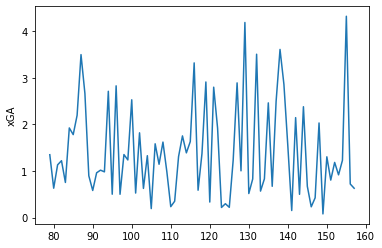

In [29]:
sns.lineplot(data=df[df["Team"]== "Aston Villa"]["xGA"])